### CBLOF Find # kmeans centroid
[Git Issue 1085](https://github.ibm.com/wiotp/monitoring-dashboard/issues/1085)

**Goal** 
Use heuristics to determine a `good` value for # centroids and analyze if it makes anomaly detection better <br/>
* stategies used to determine number of clusters Elbow method, silouetter score, and calinski harabasz <br/> 
* consider effectiveness by measuring drift in data

**Progress**
* Updated KMeansAnomalyScore module to accept num_clusters as parameter *(local iofunctions changes)*
* Analyzed the effects of changing number of clusters for the same dataset
* Peformed the same analysis on 4 datasets

#### STEPS TO ANALYZE CLUSTERING <br>

1. Select sample data<br>
2. Perform **elbow method**, **silhouette scoring**, and **calinski harabasz scoring** <br>
3. Implement max voting or avergae for determining the num of clusters (Currently using max of all cluster recoomendations) <br>
4. Analyze if num of clusters derived from above method yields better results than the hardset value of k=40<br>

#### CONCLUSION AND RECOMMENDATION <br>

---
* Picking the right threshold takes precendence over choosing the number of clusters
* Can contamination be pre-determined for a time period (by people with domain knowledge)?
* Better contamination will lead to a better threshold and anomaly detection <br>
  **contamination** : float in (0., 0.5), optional (default=0.1) <br> the proportion of outliers in the data set. Used when fitting to define the threshold on the decision function. <br>
---
* Using different number of clusters didn't show any drastic differences in the std, or range of the anomalies scores <br>
  **Reasoning** <br>
* In CBOLF Outliers scores are computed based on their distance to the closest large cluster center.
* Our clusters score~0.5 on silouetter analysis => clusters are not well-formed => for a datapoint, distance from a large cluster center remains similar when varying # clusters
* Changing the number of clusters doesn't yeild significant difference
---

#### OBSERVATION <br>

*Data 1* : **Azure Temperature Data**
* anomaly scores have std=1.03, and range [0.009, 0.75]
* Using recommended threshold has false positives
* Different threshold recommendatiosn by CBLOF on different runs
* True detection rate remains the same with different number of clusters
* Works well when setting a higher than recommended threshold 


*Data 2* : **Amrstark Good Data**
* anomaly scores have std=0.02, and are between [0.02, 0.2]
* 19 clusters recommended by elbow method
* A lot of false positives with recommended threshold
* the low range and std of anomaly scores can indicate no anomaly -> based on which we can recommend a higher threshold?
* not much change in std and range with 19 clusters or 40 clusters

*Data 3* : **Amrstark Bad Data**
* anomaly scores have std=0.11, and range [0.02, 0.67]
* 18 clusters recommended by elbow method, with recommended threhsold=0.39
* similar results with 40 clusters
* works well with the recommended thresholds - detects the anomalous motor vibrations

*Data 4* : **Synthetic Data from Anomaly Data Generator**
* anomaly scores have std=1838.18, and range [0.72, 22020.5]
* elbow methos fails for this
* calinski harabasz recommends 30 clusters
* recommended threshold of 31 is worse than chosing a bigger threshold (like 222, which is the mean)
* similar results with 40 clusters

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sb
import matplotlib.pyplot as plt

from src.comparingmodels import (utils, data, models)

import logging
from iotfunctions.enginelog import EngineLogging
EngineLogging.configure_console_logging(logging.INFO)

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**SELECT DATA TO ANALYSE** <br>
uncomment the data source you want to use

In [3]:
#Select (by uncommenting) a data source
#datapath = '../data/AzureAnomalysample.csv'; datakey='Temperature'
#datapath = '../data/Armstark04714B6046D5.csv'; datakey='ArmstarkGoodData'
datapath='../data/Armstark04714B604101.csv'; datakey='ArmstarkBadData'
#datapath = '../data/Anomaly_Sample_data.csv'; datakey='SampleAnomalyData'

**1. Data Processing**

In [4]:
#-------------------------------DATA 1-------------------------------#
if datakey is "Temperature":
    dp = data.DataProcessor(filepath=datapath, timestampcolumn='timestamp')
    dp.add_entity('MyRoom')
    dp.add_derived_column('Temperature', 'value', 20)
    dp.process_data()
    df = dp.get_data()
    df = df.drop(columns=['value'])
    #column we want to analyze
    columnname='Temperature'
    entity='MyRoom'
    
#-------------------------------DATA 2-------------------------------#
if datakey is "ArmstarkGoodData":
    dp = data.DataProcessor(filepath=datapath, timestampcolumn='RCV_TIMESTAMP_UTC')
    dp.change_column_name('entity', 'DEVICE_ID')
    dp.change_column_name('timestamp', 'RCV_TIMESTAMP_UTC')
    dp.process_data()
    df = dp.get_data()

    #filter data to specific needs
    listAttr = ['timestamp', 'entity', 'vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
                'accel_power_2', 'accel_power_3', 'accel_power_4']
    utils.l2norm(df, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
    utils.l2norm(df, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
    utils.l2norm(df, 'accel_speed', 'ACCEL_SPEED')
    utils.unrollAccel(df)
    df = df.filter(listAttr, axis=1)

    #colum we want to analyze
    columnname = 'vibrations'
    entity='04714B6046D5'
    
#-------------------------------DATA 3-------------------------------#
if datakey is "ArmstarkBadData":
    dp = data.DataProcessor(filepath=datapath, timestampcolumn='RCV_TIMESTAMP_UTC')
    dp.change_column_name('entity', 'DEVICE_ID')
    dp.change_column_name('timestamp', 'RCV_TIMESTAMP_UTC')
    dp.process_data()
    df = dp.get_data()

    #filter data to specific needs
    listAttr = ['timestamp', 'entity', 'vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
                'accel_power_2', 'accel_power_3', 'accel_power_4']
    utils.l2norm(df, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
    utils.l2norm(df, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
    utils.l2norm(df, 'accel_speed', 'ACCEL_SPEED')
    utils.unrollAccel(df)
    df = df.filter(listAttr, axis=1)

    #colum we want to analyze
    columnname = 'vibrations'
    entity='04714B604101'
    
#-------------------------------DATA 4-------------------------------#
if datakey is "SampleAnomalyData":
    dp = data.DataProcessor(filepath=datapath, timestampcolumn='EVT_TIMESTAMP')
    dp.change_column_name('entity', 'DEVICEID')
    dp.change_column_name('timestamp', 'EVT_TIMESTAMP')
    dp.drop_columns(columns=['LOGICALINTERFACE_ID', 'EVENTTYPE', 'FORMAT', 'TURBINE_ID'])
    dp.process_data()
    df = dp.get_data()
    #colum we want to analyze
    columnname = 'TEMPERATURE' #PRESSURE
    entity='A101'

X = np.array(df[columnname])
try:
    X.shape[1]
except:
    X = X.reshape(-1, 1)
    
df.head()

vibrations       rms  accel_speed  \
entity       timestamp                                                    
04714B604101 2020-01-01 00:02:12.713    3.718562  2.134730  2316.573763   
             2020-01-01 00:07:12.739    3.786815  2.136680  2324.632014   
             2020-01-01 00:12:12.769    3.653347  2.136230  2322.836628   
             2020-01-01 00:17:12.806    3.673086  2.135904  2321.045023   
             2020-01-01 00:22:13.071    3.754269  2.135181  2321.046747   

                                      accel_power_0  accel_power_1  \
entity       timestamp                                               
04714B604101 2020-01-01 00:02:12.713         2.3650         2.3388   
             2020-01-01 00:07:12.739         2.5250         2.3846   
             2020-01-01 00:12:12.769         2.5186         2.3766   
             2020-01-01 00:17:12.806         2.4960         2.3822   
             2020-01-01 00:22:13.071         2.5404         2.3874   

                                      accel_power_2  accel_power_3  \
entity       timestamp                                               
04714B604101 2020-01-01 00:02:12.713         2.3410         2.3578   
             2020-01-01 00:07:12.739         2.3978         2.3980   
             2020-01-01 00:12:12.769         2.3606         2.4578   
             2020-01-01 00:17:12.806         2.3832         2.4854   
             2020-01-01 00:22:13.071         2.3896         2.4240   

                                      accel_power_4  
entity       timestamp                               
04714B604101 2020-01-01 00:02:12.713         2.5272  
             2020-01-01 00:07:12.739         2.5762  
             2020-01-01 00:12:12.769         2.5150  
             2020-01-01 00:17:12.806         2.3844  
             2020-01-01 00:22:13.071         2.4112

**2. Elbow Method**

/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


elbow value 18
elbow score 0.6669210405290134


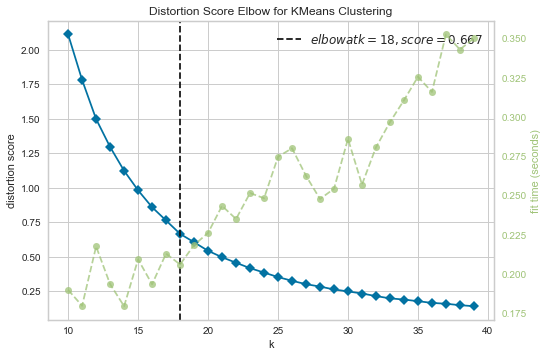

In [5]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
#timings=False to hid the green line
#metric=silhouette and calinski_harabasz
visualizer = KElbowVisualizer(KMeans(), k=(10, 40))

visualizer.fit(X)  # Fit the data to the visualizer

print(f'elbow value {visualizer.elbow_value_}')
print(f'elbow score {visualizer.elbow_score_}')
visualizer.show()  # Finalize and render the figure

**3. Silouette Scoring**

elbow value 12
elbow score 0.524579893862468


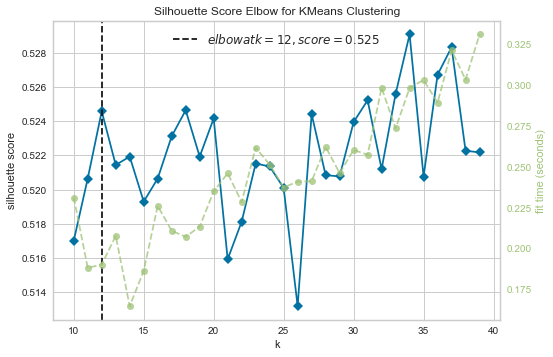

In [6]:
visualizer = KElbowVisualizer(KMeans(), k=(10,40), metric='silhouette')

visualizer.fit(X)  # Fit the data to the visualizer

print(f'elbow value {visualizer.elbow_value_}')
print(f'elbow score {visualizer.elbow_score_}')
visualizer.show()  # Finalize and render the figure

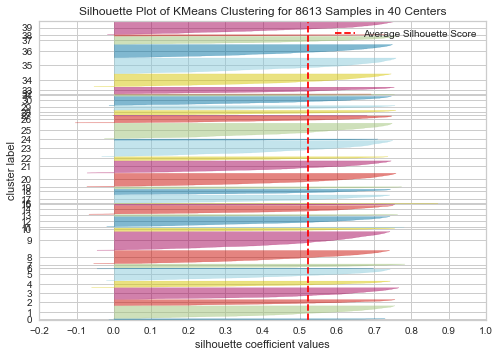

In [12]:
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = KMeans(40, random_state=50)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

**4. Calinski Harabasz**

elbow value 16
elbow score 44481.43010788117


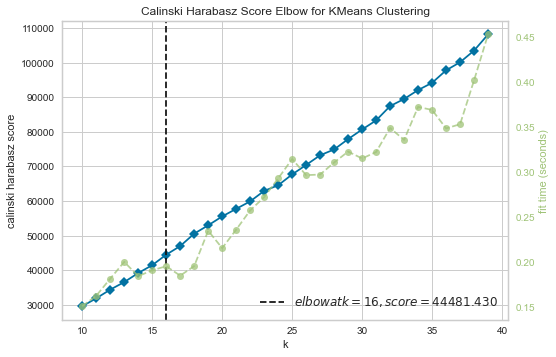

In [9]:
visualizer = KElbowVisualizer(KMeans(), k=(10,40), metric='calinski_harabasz')

visualizer.fit(X)  # Fit the data to the visualizer

print(f'elbow value {visualizer.elbow_value_}')
print(f'elbow score {visualizer.elbow_score_}')
visualizer.show()  # Finalize and render the figure

**Analyze on anomaly detection model (Running kmeans anomaly model)**

In [10]:
em = models.ExistingModels(columnname=columnname)

#add number of cluster as option
df_anomaly = em.run_kmeans(df, nclusters=40)
df_anomaly.describe()

2020-08-13T12:13:18.744 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-08-13T12:13:18.745 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-08-13T12:13:21.127 INFO iotfunctions.anomaly.execute For entity 04714B604101 CBLOF threshold: 0.36519434158864755


,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,KmeansAnomalyScore
count,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000
mean,3.714736,2.146044,2135.422189,2.408757,2.409634,2.407835,2.408529,2.409018,0.214522
std,0.088517,0.015580,693.362789,0.947978,0.948468,0.947572,0.947615,0.947830,0.105189
min,3.299344,2.120791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017351
25%,3.664859,2.134649,2304.939479,2.268600,2.268400,2.268400,2.268000,2.268600,0.149445
50%,3.701923,2.138430,2315.672257,2.352200,2.351000,2.349600,2.351600,2.352400,0.191994
75%,3.758416,2.161545,2356.449660,2.666400,2.685000,2.670600,2.671000,2.675600,0.276749
max,4.221860,2.194125,2647.057801,5.060000,4.975000,4.883400,5.401600,5.238200,0.611335


kmeans anomaly threshold: 0.365


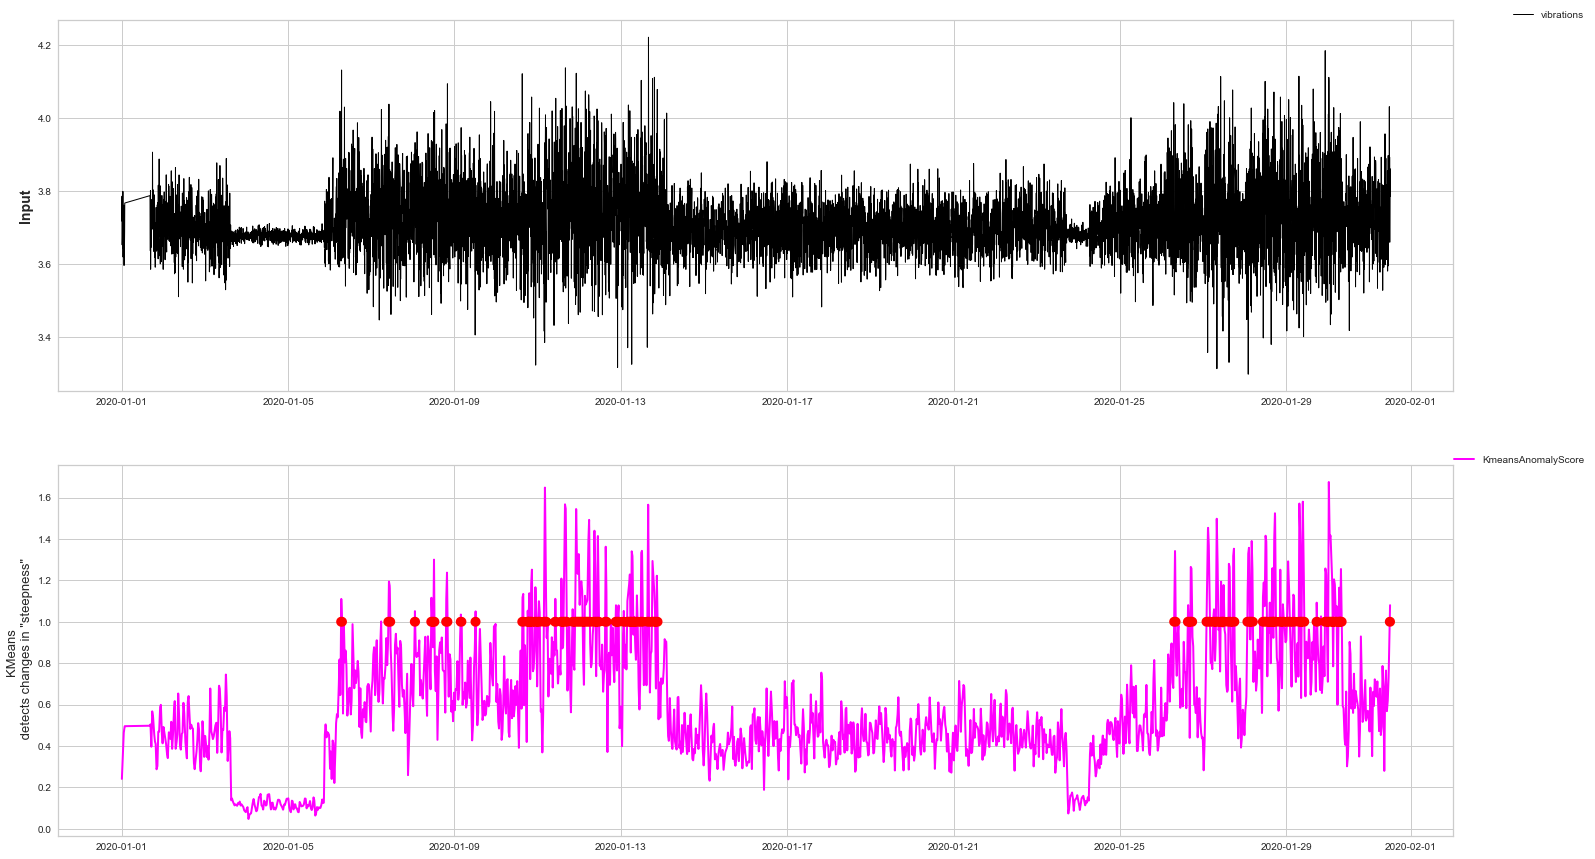

In [11]:
# Simplify dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)
df_plot = df_anomaly.loc[[entity]]
df_plot.reset_index(level=[0], inplace=True)
em.visualize_kmeans(df_plot, threshold=0.365)

**Data Drift (Not Implemented)**